# SBI with mixed data, iid data, and experimental conditions

For a general tutorial on using SBI with trial-based iid data, see `tutorial 14`. Here, we cover the use-case often occurring in models of decision-making: trial-based data with mixed data types and varying experimental conditions. 

## Trial-based SBI with mixed data types

In some cases, models with trial-based data additionally return data with mixed data types, e.g., continous and discrete data. For example, most computational models of decision-making have continuous reaction times and discrete choices as output. 

This can induce a problem when performing trial-based SBI that relies on learning a neural likelihood: It is challenging for most density estimators to handle both, continuous and discrete data at the same time. 
However, there is a recent SBI method for solving this problem, it's called __Mixed Neural Likelihood Estimation__ (MNLE). It works just like NLE, but with mixed data types. The trick is that it learns two separate density estimators, one for the discrete part of the data, and one for the continuous part, and combines the two to obtain the final neural likelihood. Crucially, the continuous density estimator is trained conditioned on the output of the discrete one, such that statistical dependencies between the discrete and continuous data (e.g., between choices and reaction times) are modeled as well. The interested reader is referred to the original paper available [here](https://elifesciences.org/articles/77220).

MNLE was recently added to `sbi` (see this [PR](https://github.com/mackelab/sbi/pull/638) and also [issue](https://github.com/mackelab/sbi/issues/845)) and follows the same API as `SNLE`.

In this tutorial we will show how to apply `MNLE` to mixed data, and how to deal with varying experimental conditions. 

## Toy problem for `MNLE`

To illustrate `MNLE` we set up a toy simulator that outputs mixed data and for which we know the likelihood such we can obtain reference posterior samples via MCMC.

__Simulator__: To simulate mixed data we do the following

- Sample reaction time from `inverse Gamma`
- Sample choices from `Binomial`
- Return reaction time $rt \in (0, \infty)$ and choice index $c \in \{0, 1\}$

$$
c \sim \text{Binomial}(\rho) \\
rt \sim \text{InverseGamma}(\alpha=2, \beta) \\
$$




__Prior__: The priors of the two parameters $\rho$ and $\beta$ are independent. We define a `Beta` prior over the probabilty parameter of the `Binomial` used in the simulator and a `Gamma` prior over the shape-parameter of the `inverse Gamma` used in the simulator:

$$
p(\beta, \rho) = p(\beta) \; p(\rho) ; \\
p(\beta) = \text{Gamma}(1, 0.5) \\
p(\text{probs}) = \text{Beta}(2, 2) 
$$

Because the `InverseGamma` and the `Binomial` likelihoods are well-defined we can perform MCMC on this problem and obtain reference-posterior samples.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor


from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Categorical, Gamma
from sbi.utils import MultipleIndependent
from sbi.utils.metrics import c2st

from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.inference.potentials.likelihood_based_potential import (
    MixedLikelihoodBasedPotential,
)
from sbi.utils.conditional_density_utils import ConditionedPotential

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

In [2]:
# Toy simulator for mixed data
def mixed_simulator(theta: Tensor, concentration_scaling: float = 1.0):
    """Returns a sample from a mixed distribution given parameters theta.

    Args:
        theta: batch of parameters, shape (batch_size, 2)
        concentration_scaling: scaling factor for the concentration parameter of the InverseGamma distribution, mimics an experimental condition.

    """
    beta, ps = theta[:, :1], theta[:, 1:]

    choices = Binomial(probs=ps).sample()
    rts = InverseGamma(
        concentration=concentration_scaling * torch.ones_like(beta), rate=beta
    ).sample()

    return torch.cat((rts, choices), dim=1)


# The potential function defines the ground truth likelihood and allows us to obtain reference posterior samples via MCMC.
class PotentialFunctionProvider(BasePotential):
    allow_iid_x = True  # type: ignore

    def __init__(self, prior, x_o, concentration_scaling=1.0, device="cpu"):
        super().__init__(prior, x_o, device)
        self.concentration_scaling = concentration_scaling

    def __call__(self, theta, track_gradients: bool = True):
        theta = atleast_2d(theta)

        with torch.set_grad_enabled(track_gradients):
            iid_ll = self.iid_likelihood(theta)

        return iid_ll + self.prior.log_prob(theta)

    def iid_likelihood(self, theta):
        lp_choices = torch.stack(
            [
                Binomial(probs=th.reshape(1, -1)).log_prob(self.x_o[:, 1:])
                for th in theta[:, 1:]
            ],
            dim=1,
        )

        lp_rts = torch.stack(
            [
                InverseGamma(
                    concentration=self.concentration_scaling * torch.ones_like(beta_i),
                    rate=beta_i,
                ).log_prob(self.x_o[:, :1])
                for beta_i in theta[:, :1]
            ],
            dim=1,
        )

        joint_likelihood = (lp_choices + lp_rts).squeeze()

        assert joint_likelihood.shape == torch.Size([self.x_o.shape[0], theta.shape[0]])
        return joint_likelihood.sum(0)

In [3]:
# Define independent prior.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)

### Obtain reference-posterior samples via analytical likelihood and MCMC

In [4]:
torch.manual_seed(42)
num_trials = 10
num_samples = 1000
theta_o = prior.sample((1,))
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))

In [5]:
mcmc_kwargs = dict(
    num_chains=20,
    warmup_steps=50,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

true_posterior = MCMCPosterior(
    potential_fn=PotentialFunctionProvider(prior, x_o),
    proposal=prior,
    theta_transform=mcmc_transform(prior, enable_transform=True),
    **mcmc_kwargs,
)
true_samples = true_posterior.sample((num_samples,))

/Users/janbolts/qode/sbi/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

### Train MNLE and generate samples via MCMC

In [6]:
# Training data
num_simulations = 20000
# For training the MNLE emulator we need to define a proposal distribution, the prior is
# a good choice.
proposal = prior
theta = proposal.sample((num_simulations,))
x = mixed_simulator(theta)

# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE()
estimator = trainer.append_simulations(theta, x).train(training_batch_size=1000)

/Users/janbolts/qode/sbi/sbi/neural_nets/mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 73 epochs.

In [8]:
# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

### Compare MNLE and reference posterior

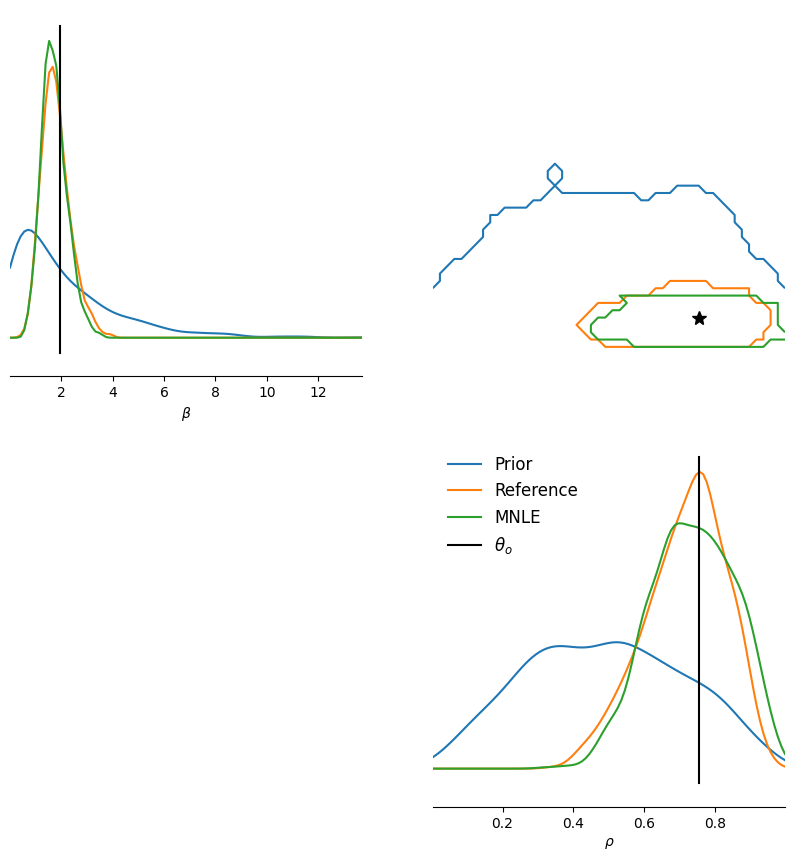

In [9]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

We see that the inferred `MNLE` posterior nicely matches the reference posterior, and how both inferred a posterior that is quite different from the prior.

Because MNLE training is amortized we can obtain another posterior given a different observation with potentially a different number of trials, just by running MCMC again (without re-training `MNLE`):

### Repeat inference with different `x_o` that contains more trials

In [10]:
num_trials = 50
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))
true_samples = true_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

/Users/janbolts/qode/sbi/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 50 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

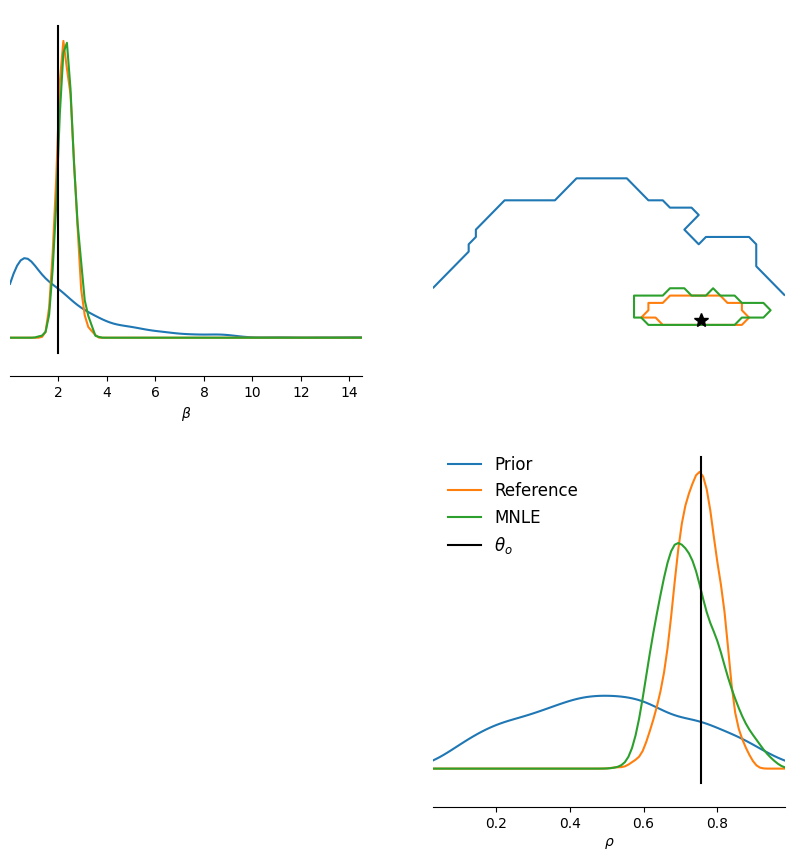

In [11]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

In [12]:
print(c2st(true_samples, mnle_samples)[0])

tensor(0.5565)


Again we can see that the posteriors match nicely. In addition, we observe that the posterior's (epistemic) uncertainty reduces as we increase the number of trials. 

Note: `MNLE` is trained on single-trial data. Theoretically, density estimation is perfectly accurate only in the limit of infinite training data. Thus, training with a finite amount of training data naturally induces a small bias in the density estimator. 
As we observed above, this bias is so small that we don't really notice it, e.g., the `c2st` scores were close to 0.5. 
However, when we increase the number of trials in `x_o` dramatically (on the order of 1000s) the small bias can accumulate over the trials and inference with `MNLE` can become less accurate.

## MNLE with experimental conditions

In the perceptual decision-making research it is common to design experiments with varying experimental decisions, e.g., to vary the difficulty of the task. 
During parameter inference, it can be beneficial to incorporate the experimental conditions. 
In MNLE, we are learning an emulator that should be able to generate synthetic experimental data including reaction times and choices given different experimental conditions. 
Thus, to make MNLE work with experimental conditions, we need to include them in the training process, i.e., treat them like auxiliary parameters of the simulator: 

In [13]:
# define a simulator wrapper in which the experimental condition are contained in theta and passed to the simulator.
def sim_wrapper(theta):
    # simulate with experiment conditions
    return mixed_simulator(
        theta=theta[:, :2],
        concentration_scaling=theta[:, 2:]
        + 1,  # add 1 to deal with 0 values from Categorical distribution
    )

In [14]:
# Define a proposal that contains both, priors for the parameters and a discrte prior over experimental conditions.
proposal = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
        Categorical(probs=torch.ones(1, 3)),
    ],
    validate_args=False,
)

# Simulated data
num_simulations = 10000
num_samples = 1000
theta = proposal.sample((num_simulations,))
x = sim_wrapper(theta)
assert x.shape == (num_simulations, 2)

# simulate observed data and define ground truth parameters
num_trials = 10
theta_o = proposal.sample((1,))
theta_o[0, 2] = 2.0  # set condition to 2 as in original simulator.
x_o = sim_wrapper(theta_o.repeat(num_trials, 1))

#### Obtain ground truth posterior via MCMC

We obtain a ground-truth posterior via MCMC by using the PotentialFunctionProvider.

For that, we first the define the actual prior, i.e., the distribution over the parameter we want to infer (not the proposal).

Thus, we leave out the discrete prior over experimental conditions.

In [15]:
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)
prior_transform = mcmc_transform(prior)

# We can now use the PotentialFunctionProvider to obtain a ground-truth posterior via MCMC.
true_posterior_samples = MCMCPosterior(
    PotentialFunctionProvider(
        prior,
        x_o,
        concentration_scaling=float(theta_o[0, 2])
        + 1.0,  # add one because the sim_wrapper adds one (see above)
    ),
    theta_transform=prior_transform,
    proposal=prior,
    **mcmc_kwargs,
).sample((num_samples,), show_progress_bars=True)

/Users/janbolts/qode/sbi/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

### Train MNLE including experimental conditions

In [16]:
trainer = MNLE(proposal)
estimator = trainer.append_simulations(theta, x).train(training_batch_size=100)

/Users/janbolts/qode/sbi/sbi/neural_nets/mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 73 epochs.

### Construct conditional potential function

To obtain posterior samples conditioned on a particular experimental condition (and on x_o), we need to construct a corresponding potential function.

In [17]:
# First, we define the potential function for the complete, unconditional MNLE-likelihood.
potential_fn = MixedLikelihoodBasedPotential(estimator, proposal, x_o)

# Then we use the potential to construct the conditional potential function.
# Here, we tell the constructor to condition on the last dimension (index 2) by passing dims_to_sample=[0, 1].
conditioned_potential_fn = ConditionedPotential(
    potential_fn,
    condition=theta_o,
    dims_to_sample=[0, 1],
    allow_iid_x=True,  # we also need to explicitly tell that MNLE allows iid_x
)

# Using this potential function, we can now obtain conditional samples.
mnle_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=prior_transform,
    proposal=prior,
    **mcmc_kwargs
)
conditional_samples = mnle_posterior.sample((num_samples,), x=x_o)

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

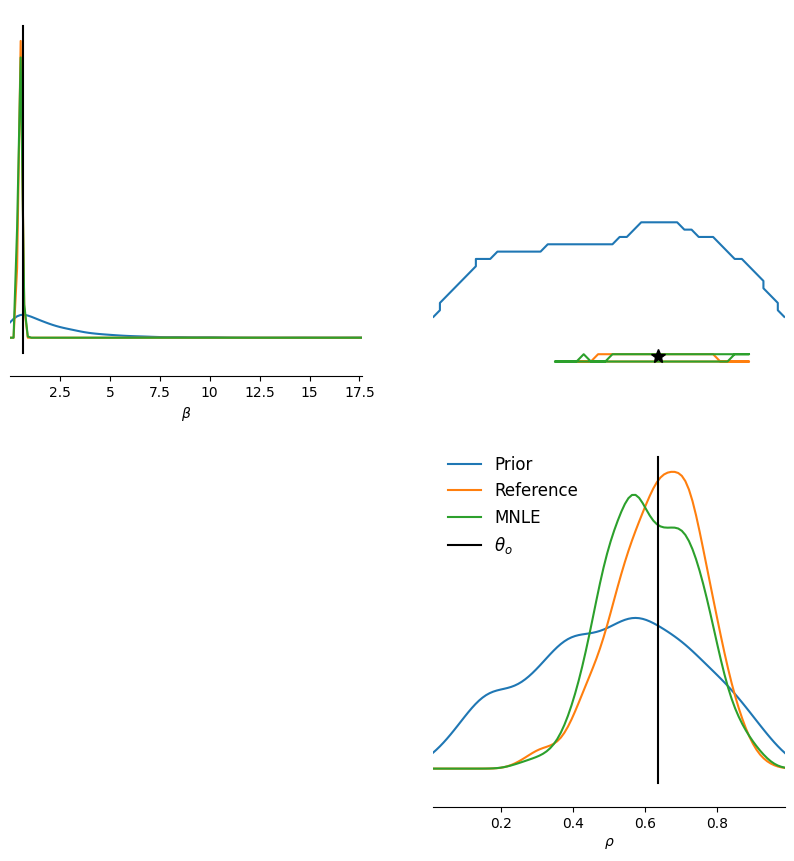

In [18]:
# Finally, we can compare the ground truth conditional posterior with the MNLE-conditional posterior.
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_posterior_samples,
        conditional_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

They match accurately, showing that we can indeed post-hoc condition the trained MNLE likelihood on different experimental conditions.